# Neural Network with Entity Embeddings + Class Weights

This notebook trains a neural network using entity embeddings for categorical features. This enables true entity embeddings that can learn semantic relationships between categorical values.

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from sklearn.metrics import classification_report, accuracy_score, f1_score

from src.preprocessing_pipeline import build_preprocessed_data

In [2]:
print("Loading and preprocessing data (WITH Class Weights + EMBEDDING format)...")
data = build_preprocessed_data(
    use_smote=False,
    impute_strategy='subgroup_mean',
    output_format='embedding',
)

# Extract data
X_train_cat = data["X_train_cat"]
X_train_cont = data["X_train_cont"]
y_train = data["Y_train"].astype('int32')

X_val_cat = data["X_val_cat"]
X_val_cont = data["X_val_cont"]
y_val = data["Y_val"].astype('int32')

X_test_cat = data["X_test_cat"]
X_test_cont = data["X_test_cont"]
y_test = data["Y_test"].astype('int32')

# Metadata for features
categorical_info = data["categorical_info"]
cols_categorical = data["cols_categorical"]
cols_continuous = data["cols_continuous"]

print(f"\nCategorical features: {cols_categorical}")
print(f"Categorical shape: {X_train_cat.shape}")
print(f"Continuous shape: {X_train_cont.shape}")
print(f"\nEmbedding configuration:")
for col, info in categorical_info.items():
    print(f"  {col}: {info['num_categories']} categories -> {info['embed_dim']}D embedding")

Loading and preprocessing data (WITH SMOTENC + EMBEDDING format)...
[Memory] Pipeline start: 0.66 GB
Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.
[Memory] After data load: 28.38 GB
Loaded 2302521 rows
[Memory] After sampling: 24.02 GB
Imputing with subgroup mean (GACC_PL)...

Preparing data for embedding model (label-encoded categoricals)...
[Memory] Pipeline complete: 22.09 GB

Categorical features: ['NWCG_CAUSE_CLASSIFICATION', 'GACC_PL']
Categorical shape: (2400, 2)
Continuous shape: (2400, 43)

Embedding configuration:
  NWCG_CAUSE_CLASSIFICATION: 4 categories -> 2D embedding
  GACC_PL: 7 categories -> 4D embedding


In [15]:
def build_embedding_model(categorical_info, num_continuous, num_classes,
                           l2_reg=0.01, dropout_rate=0.5):
    """
    Build a neural network with embeddings for categorical features.
    
    Architecture:
    - Each categorical feature gets its own Embedding layer
    - Embeddings are flattened and concatenated
    - Continuous features are processed through dense layer
    - Both paths are concatenated for final classification
    
    Args:
        categorical_info: dict with {col_name: {'num_categories': int, 'embed_dim': int, 'col_idx': int}}
        num_continuous: number of continuous features
        num_classes: number of output classes
    """

    cat_inputs = []
    cat_embeddings = []
    
    # Sort by col_idx to maintain proper order
    sorted_cats = sorted(categorical_info.items(), key=lambda x: x[1]['col_idx'])
    for feat_name, config in sorted_cats:
        # Input for this categorical (single integer value)
        inp = layers.Input(shape=(1,), dtype='int32', name=f'input_{feat_name}')
        cat_inputs.append(inp)
        
        # Embedding layer
        # input_dim = num_categories + 1 for potential OOV values
        emb = layers.Embedding(
            input_dim=config['num_categories'] + 1,
            output_dim=config['embed_dim'],
            embeddings_regularizer=regularizers.l2(l2_reg),
            name=f'embed_{feat_name}'
        )(inp)
        
        # Flatten
        emb = layers.Flatten(name=f'flatten_{feat_name}')(emb)
        cat_embeddings.append(emb)

    continuous_input = layers.Input(shape=(num_continuous,), dtype='float32', name='input_continuous')
    
    # Small dense layer to process continuous features
    cont_processed = layers.Dense(
        32, activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        name='continuous_dense')(continuous_input)
    cont_processed = layers.BatchNormalization(name='continuous_bn')(cont_processed)
    cont_processed = layers.Dropout(dropout_rate * 0.5, name='continuous_dropout')(cont_processed)

    if cat_embeddings:
        all_embeddings = layers.Concatenate(name='concat_embeddings')(cat_embeddings)
        x = layers.Concatenate(name='concat_all')([all_embeddings, cont_processed])
    else:
        x = cont_processed

    # Classification Head
    x = layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        name='dense_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.Dropout(0.3, name='dropout_1')(x)
    
    x = layers.Dense(
        32,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        name='dense_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.Dropout(0.2, name='dropout_2')(x)

    # Output
    output = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=regularizers.l2(l2_reg),
        name='output')(x)
    
    # Build model
    all_inputs = cat_inputs + [continuous_input]
    model = Model(inputs=all_inputs, outputs=output, name='EntityEmbeddingModel')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [16]:
# Build model
num_classes = len(np.unique(y_train))
num_continuous = X_train_cont.shape[1]

print(f"Number of continuous features: {num_continuous}")
print(f"Number of classes: {num_classes}")

model = build_embedding_model(
    categorical_info=categorical_info,
    num_continuous=num_continuous,
    num_classes=num_classes
)

model.summary()

Number of continuous features: 43
Number of classes: 4
Model: "EntityEmbeddingModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_NWCG_CAUSE_CLASSIFIC  [(None, 1)]                  0         []                            
 ATION (InputLayer)                                                                               
                                                                                                  
 input_GACC_PL (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 input_continuous (InputLay  [(None, 43)]                 0         []                            
 er)                                                                                              
                        

In [17]:
def prepare_model_inputs(X_cat, X_cont, categorical_info):
    """
    Prepares a list of inputs for the multi-input embedding model keeping correct order.
    
    Returns a list: [cat_col_0, cat_col_1, ..., continuous_features]
    """
    inputs = []
    
    # Sort categorical columns by index to match model input order
    sorted_cats = sorted(categorical_info.items(), key=lambda x: x[1]['col_idx'])
    
    # Add each categorical column as separate input
    for feat_name, config in sorted_cats:
        col_idx = config['col_idx']
        inputs.append(X_cat[:, col_idx])
    
    # Add continuous features
    inputs.append(X_cont)
    
    return inputs

# Prepare inputs
train_inputs = prepare_model_inputs(X_train_cat, X_train_cont, categorical_info)
val_inputs = prepare_model_inputs(X_val_cat, X_val_cont, categorical_info)
test_inputs = prepare_model_inputs(X_test_cat, X_test_cont, categorical_info)

print(f"Number of model inputs: {len(train_inputs)}")
print(f"Input shapes: {[x.shape for x in train_inputs]}")

Number of model inputs: 3
Input shapes: [(2400,), (2400,), (2400, 43)]


In [18]:
# Train Model
print("Training Entity Embedding Neural Network...")

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=50,
    batch_size=2048,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training Entity Embedding Neural Network...
Epoch 1/50
2/2 [==============================] - 2s 214ms/step - loss: 3.4298 - accuracy: 0.2279 - val_loss: 2.8349 - val_accuracy: 0.2862 - lr: 0.0010
Epoch 2/50
2/2 [==============================] - 0s 61ms/step - loss: 3.2985 - accuracy: 0.2525 - val_loss: 2.7822 - val_accuracy: 0.2950 - lr: 0.0010
Epoch 3/50
2/2 [==============================] - 0s 71ms/step - loss: 3.1949 - accuracy: 0.2688 - val_loss: 2.7362 - val_accuracy: 0.2950 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - 0s 68ms/step - loss: 3.1109 - accuracy: 0.2937 - val_loss: 2.6960 - val_accuracy: 0.3038 - lr: 0.0010
Epoch 5/50
2/2 [==============================] - 0s 65ms/step - loss: 3.0856 - accuracy: 0.2775 - val_loss: 2.6605 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 6/50
2/2 [==============================] - 0s 57ms/step - loss: 2.9878 - accuracy: 0.3192 - val_loss: 2.6295 - val_accuracy: 0.3225 - lr: 0.0010
Epoch 7/50
2/2 [===========================

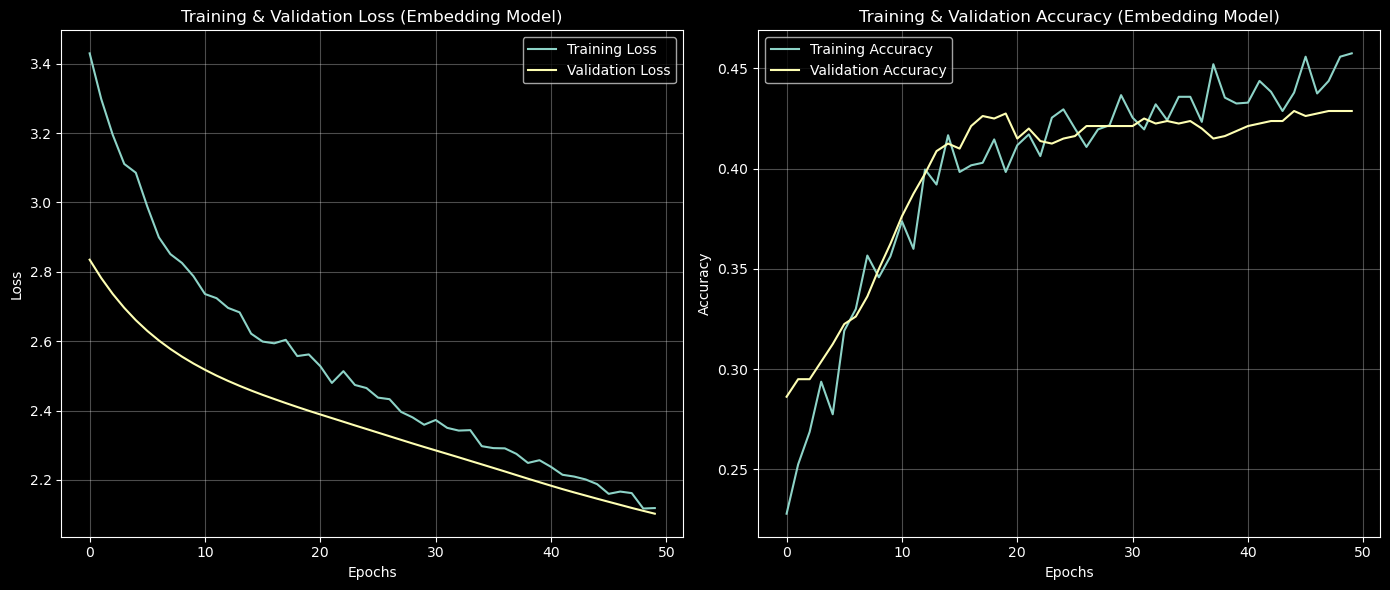

In [19]:
plt.style.use('dark_background')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left Plot: Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training & Validation Loss (Embedding Model)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right Plot: Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy (Embedding Model)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Evaluate on Validation Set
print("Evaluating on Validation Set...")
y_pred_val_prob = model.predict(val_inputs)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Validation Macro F1: {f1_score(y_val, y_pred_val, average='macro'):.4f}")
print("\nClassification Report (Validation):\n")
print(classification_report(y_val, y_pred_val))

Evaluating on Validation Set...
25/25 [==============================] - 0s 4ms/step
Validation Accuracy: 0.4288
Validation Macro F1: 0.3697

Classification Report (Validation):

              precision    recall  f1-score   support

           0       0.58      0.68      0.62       200
           1       0.40      0.18      0.25       200
           2       0.23      0.05      0.08       214
           3       0.38      0.87      0.52       186

    accuracy                           0.43       800
   macro avg       0.40      0.44      0.37       800
weighted avg       0.39      0.43      0.36       800

